In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 180 (delta 78), reused 134 (delta 49), pack-reused 0
Receiving objects: 100% (180/180), 28.64 MiB | 31.37 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=a2224907170e9e027414414472eec0ec4923231b4ee2072ad5e99a29f064fdfb
  Stored in directory: /tmp/pip-ephem-wheel-cache-b19kzild/wheels/55/59/29/0fb1c63565215773

In [2]:
from dul_2021.utils.hw3_utils import *


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


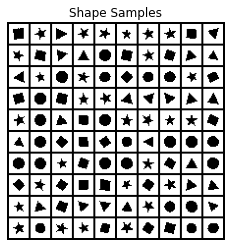

In [3]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [43]:
import itertools
import os
from scipy.optimize import bisect
from typing import Tuple

import numpy as np
import copy
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MaskedConv(nn.Conv2d):
    def __init__(self, *args, type=1, is_conditional=False, n_groups=3, **kwargs):
        super().__init__(*args, **kwargs)
        # weight.shape = (out_channels, in_channels, conv_size, conv_size)
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.set_mask(type, is_conditional, n_groups)

    def forward(self, x):
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, stride=self.stride, padding=self.padding)

    def set_mask(self, type, is_conditional, n_groups):
        h, w = self.kernel_size
        out_channels, in_channels = self.weight.shape[:2]

        self.mask[:, :, h // 2, : w // 2] = 1
        self.mask[:, :, : h // 2] = 1
        if is_conditional:
            for g in range(n_groups):
                self.mask[
                out_channels // 3 * g: out_channels // 3 * (g + 1), : in_channels // 3 * (g + type), h // 2, w // 2
                ] = 1
        if not is_conditional and type == 1:
            self.mask[:, :, h // 2, w // 2] = 1


class ResidualBlock(nn.Module):
    def __init__(self, inc, conv_size, is_conditional=False):
        super().__init__()
        h = inc // 2

        self.main = nn.Sequential(
            MaskedConv(in_channels=inc, out_channels=h, kernel_size=1, is_conditional=is_conditional),
            nn.ReLU(),
            MaskedConv(in_channels=h, out_channels=h, kernel_size=conv_size, padding=3, is_conditional=is_conditional),
            nn.ReLU(),
            MaskedConv(in_channels=h, out_channels=inc, kernel_size=1, is_conditional=is_conditional),
        )

        self.ln = LayerNorm(is_conditional, inc // 3 if is_conditional else inc)

    def forward(self, x):
        return self.ln(F.relu(self.main(x) + x))


class LayerNorm(nn.LayerNorm):
    def __init__(self, color_conditioning, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.color_conditioning = color_conditioning

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        if self.color_conditioning:
            x = x.contiguous().view(*(x_shape[:-1] + (3, -1)))
        x = super().forward(x)
        if self.color_conditioning:
            x = x.view(*x_shape)
        return x.permute(0, 3, 1, 2).contiguous()


class PixelCNN(nn.Module):
    def __init__(
            self,
            input_shape: Tuple[int, int, int],
            n_gauss: int,
            conv_size: int = 7,
            feature_maps: int = 64,
            n_convs: int = 4,
            is_conditional: bool = False,
    ):
        super().__init__()
        self.h, self.w, self.c = input_shape
        self.n_gauss = n_gauss
        self.is_conditional = is_conditional

        init_conv = [
            MaskedConv(self.c, feature_maps, conv_size, 1, 3, type=0, is_conditional=is_conditional),
            LayerNorm(is_conditional, feature_maps),
            nn.ReLU(),
        ]

        hidden_convs = [ResidualBlock(feature_maps, conv_size, is_conditional=is_conditional) for _ in range(n_convs)]

        dense_convs = [
            MaskedConv(feature_maps, feature_maps, 1, is_conditional=is_conditional),
            nn.ReLU(),
        ]

        last_conv = [MaskedConv(feature_maps, 3 * n_gauss, 1, is_conditional=is_conditional)]

        self.model = nn.Sequential(*(init_conv + hidden_convs + dense_convs + last_conv))

    def forward(self, x):
        # out = (x / (self.n_classes - 1) - 0.5) / 0.5
        params = self.model(x)
        mu, log_sigma, log_w = params.chunk(chunks=3, dim=1)

        return mu, log_sigma, log_w


class Flow(nn.Module):
    def __init__(self, n_gauss: int = 5, **kwargs):
        super().__init__()
        self.n_gauss = n_gauss
        self.c = 1
        self.input_shape = (20, 20, 1)
        self.pcnn = PixelCNN(n_gauss=n_gauss, **kwargs)

    def forward(self, x):
        return self.pcnn(x)

    @property
    def device(self):
        return next(iter(self.parameters())).device

    @property
    def base_dist(self):
        return torch.distributions.Uniform(torch.FloatTensor([0]).to(self.device),
                                           torch.FloatTensor([1]).to(self.device))

    def forward_flow(self, x):
        # getting parameters for the mixture
        mu, log_sigma, log_w = self.pcnn(x)

        sigma = log_sigma.exp()
        w = log_w.softmax(dim=1)
        dist = torch.distributions.Normal(mu, sigma)

        z = (dist.cdf(x) * w).sum(dim=1)

        log_det = (dist.log_prob(x).exp() * w).sum(dim=1).log()

        return z, log_det

    def _log_prob(self, batch):
        z, log_det = self.forward_flow(batch)
        z = torch.clip(z, 0, 1)

        return (self.base_dist.log_prob(z) + log_det).mean(dim=(-1, -2))

    def nll(self, x):
        return -self._log_prob(x).mean()

    @torch.no_grad()
    def sample(self, n=100, device="cpu"):
        samples = torch.zeros(n, self.c, self.input_shape[0], self.input_shape[1], device=device)
        generation_bar = tqdm(total=self.input_shape[0] * self.input_shape[1], desc="Generating")
        for i in range(self.input_shape[0]):
            for j in range(self.input_shape[1]):
                mu, log_sigma, log_w = [t[..., i, j] for t in self(samples)]

                # take pixel-channel specific values
                w = F.softmax(log_w, dim=1)

                samples[:, 0, i, j] = self.pixel_inverse_flow(w, mu, log_sigma)

                generation_bar.update(1)
        generation_bar.close()
        return samples.clip(0, 1).cpu().numpy().transpose(0, 2, 3, 1)

    @torch.no_grad()
    def pixel_inverse_flow(self, w, mu, log_s):
        batch_size = w.shape[0]
        z = self.base_dist.sample((batch_size,))

        pixel_values = []
        for i in range(batch_size):
            dist = torch.distributions.Normal(mu[i], log_s[i].exp())

            def f(x):
                # x1 = torch.FloatTensor(np.repeat(x, self.n_gauss))
                x2 = torch.FloatTensor([x]).to(self.device)
                return w[i] @ dist.cdf(x2) - z[i]

            pixel_values.append(bisect(f, -20, 20))

        return torch.FloatTensor(pixel_values)


class Trainer:
    def __init__(self, n_epochs, lr, grad_clip=None, device=DEVICE):
        self.n_epochs = n_epochs
        self.device = device
        self.lr = lr
        self.grad_clip = grad_clip

    def fit(self, model, train_loader, val_loader):
        train_loss = []
        test_loss = []

        optimizer = opt.Adam(model.parameters(), lr=self.lr)

        model.to(self.device)
        test_loss.append(self.evaluate(model, val_loader))
        for epoch in range(self.n_epochs):
            model.train()
            tqdm_steps = tqdm(train_loader, desc=f"Training")
            for batch in tqdm_steps:
                loss = self.train_step(model, batch)

                optimizer.zero_grad()
                loss.backward()
                if self.grad_clip:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), self.grad_clip)
                optimizer.step()

                train_loss.append(loss.cpu().item())
                tqdm_steps.set_postfix(train_loss=train_loss[-1])

            test_loss.append(self.evaluate(model, val_loader))

        return train_loss, test_loss

    def train_step(self, model, batch, deq=True):
        x = batch.to(self.device, dtype=torch.float32)

        if deq:
            x = torch.clip((x + torch.rand(batch.shape, device=self.device)) / 2.0, 0, 1)

        loss = model.nll(x)
        return loss

    @torch.no_grad()
    def evaluate(self, model, val_loader):
        losses = []
        model.eval()
        for batch in val_loader:
            loss = self.train_step(model, batch, False)
            losses.append(loss.item())

        return np.mean(losses)


def q1(train_data, test_data):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    H = W = 20
    Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
        and [0.5,1] represents a white pixel. We will show your samples with and without noise.
    """
    image_shape = (20, 20, 1)
    batch_size = 128
    n_epochs = 5
    lr = 1e-3
    n_convs = 6
    feature_maps = 2 * 3 * 20
    device = torch.device("cuda")
    grad_clip = 1
    n_gauss = 10

    train_data = train_data.transpose(0, 3, 1, 2)
    test_data = test_data.transpose(0, 3, 1, 2)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=batch_size)

    model = Flow(
        n_gauss=n_gauss,
        input_shape=image_shape,
        conv_size=7,
        n_convs=n_convs,
        feature_maps=feature_maps,
        is_conditional=False,
    )

    trainer = Trainer(n_epochs=n_epochs, lr=lr, grad_clip=grad_clip, device=device)

    tr_loss, te_loss = trainer.fit(model, train_loader, val_loader)

    samples = model.sample(device=device)

    return tr_loss, te_loss, samples

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



Training:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/82 [00:00<?, ?it/s]

Generating:   0%|          | 0/400 [00:00<?, ?it/s]

Final Test Loss: 0.0959


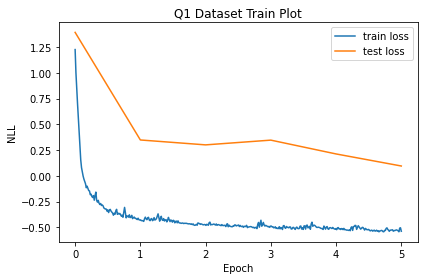

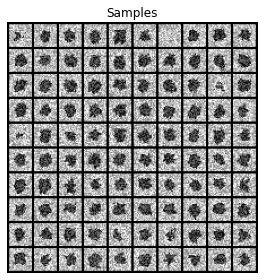

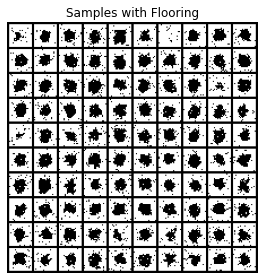

In [44]:
q1_save_results(q1)